# Solar Power Data Modeling Part 1

#### Prepared By: Ben Chamblee -https://github.com/Bench-amblee

## Contents

* [Introduction](#Introduction)  
* [Imports](#Imports)  
* [Objectives](#Objectives)  
* [Initial Prediction Using Equations](#Initial_Prediction_Using_Equations)  
* [Model Selection](#Model_Selection)  
    * [Linear Regression](#Linear_Regression)  
    * [Random Forest](#Random_Forest)  
    * [Gradient Boosting](#Gradient_Boosting)  
* [Testing Each Model Against Predicted Data](#Testing_Each_Model_Against_Predicted_Data)  
* [Gandikota Historical Data and Model Performance](#Gandikota_Historical_Data_and_Model_Performance)  
* [Predicting Power Output for 2021](#Predicting_Power_Output_for_2021)  
* [Conclusion and Next Steps](#Conclusion_and_Next_Steps)  

## Introduction

Now that we've found all relevant variable relationships, developed two prediction equations, and run an initial test of a linear regression model, we're able to create the real power output prediction model for our solar power plants. If we use all our information to accurately predict the plants' power output, we can then test many different variables for improved results.

For simplicity's sake we're going to move on with just the gandikota power plant. This is for three reasons:
1. We've determined that both plants are basically similar and have the same problem - their arrays are underperforming and need to be upgraded to have a NOCT value closer to industry average
2. To create a more accurate prediction i actually had to purchase 20 years of weather data from the gandikota region, I would prefer to not have to make another purchase just for the nashik region
3. It would make the notebook incredibly long

Now with that being said, here are some of the questions we can think to answer once we've perfected our model:

- What if each array had a higher NOCT value? How much more power would the plant output? 
- How quickly could the plants recuperate their losses by upgrading their arrays to produce more power? 
- How much power will each plant generate in a full year?

If we use the right model to prove that our prediction formulas are very similar to our real data output, we can answer these questions.

To find the right machine learning model, we'll need to test our equation's predicted values against the model's predicted values. This way we can verify that the machine learning model is accurate based on the accuracy we've achieved for these equations.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gandikota = pd.read_csv('Data/Plant1_Data_Cleaned.csv')
gandikota_avg = pd.read_csv('Data/gandikota_averages.csv')
gand_coefs = pd.read_csv('Data/gand_coefs.csv')
noct = pd.read_csv('Data/noct_df.csv')

## Objectives

- Use both the NOCT and Power Generation Equation to make a full prediction of the plant's power output
- Test at least three different model types to determine which one works best
- If our equation fits, use it to predict the output of the plant and test other features like a higher NOCT

## Initial Prediction Using Equations<a id='Initial_Prediction_Using_Equations'></a>

We have two equations to work with, the first one determines the temperature of the cell using the Nominal Operating Cell Temperature (NOCT):

![](images/NOCT_calculation.JPG)

The second one determines the power output, using the cell temperature and the coefficients we found in the last notebook:

![](images/power_equation.png)

Lets start with the first equation in the gandikota dataset

In [2]:
gandikota_avg.head()

,Unnamed: 0,DC_Power_kW,AC_Power_kW,Daily_Yield_kW,Ambient_Temperature_C,Module_Temperature_C,Irradition
0,2020-05-15 00:00:00,0.0,0.0,0.0,24.039574,21.818530,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.0,23.944380,21.727047,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.0,23.802309,21.565383,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.0,23.716761,21.344450,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.0,24.621525,22.165423,0.0


In [3]:
noct['gandikota'][0]

18.351840029094472

Now lets fill in the variables for the first equation using this data

In [4]:
T_Cell_pred = []
for i in range(len(gandikota_avg)):
    T_Air = gandikota_avg['Ambient_Temperature_C'][i]
    NOCT =  noct['gandikota'][0]
    S = gandikota_avg['Irradition'][i]*1000
    T_Cell = T_Air + ((NOCT - 20)/80)*S
    T_Cell_pred.append(T_Cell)
gandikota_avg['T_Cell_pred'] = T_Cell_pred

Now the second equation

In [5]:
Power_pred = []
for i in range(len(gandikota_avg)):
    T_Cell = gandikota_avg['T_Cell_pred'][i]
    a = gand_coefs['a'][0]
    b = gand_coefs['b'][0]
    c = gand_coefs['c'][0]
    Power = T_Cell*a*b*c
    Power_pred.append(Power)
gandikota_avg['Power_pred'] = Power_pred

Combining both equations will only give the power output for each 15 minute interval, to make a prediction for the cumulative power sum (daily yield) we'll need to make a column that sums all the power from the beginning of the day (00:00:00) to the end (23:45:00)

In this case, this happens every 92 rows in the average dataset

In [6]:
Daily_Yield_pred = []
for i in range(len(gandikota_avg)):
    f = i-1
    if f < 0:
        pred = 0
    else:
        pred = gandikota_avg['Power_pred'][i]
    Daily_Yield_pred.append(pred)
    
for i in range(len(Daily_Yield_pred)):
    f = i-1
    if f < 0:
        pred_sum = 0
    pred_sum = Daily_Yield_pred[i] + Daily_Yield_pred[f]
    if i % 92 == 0:
        Daily_Yield_pred[i] = 0
    else:
        Daily_Yield_pred[i] = pred_sum
gandikota_avg['Daily_Yield_pred'] = Daily_Yield_pred

In [7]:
x = sum(gandikota_avg['Daily_Yield_kW'])
y = sum(gandikota_avg['Daily_Yield_pred'])
print('Real average power output: ',x)
print('Predicted average power output: ',y)
print('Total difference (in kW)',x-y)
print('Coefficient: ',y/x)


Real average power output:  10303078.718452102
Predicted average power output:  10303075.359881079
Total difference (in kW) 3.358571022748947
Coefficient:  0.9999996740225796


Impressive, just a three kilowatt difference? That's amazing! Lets see what this looks liked graphed

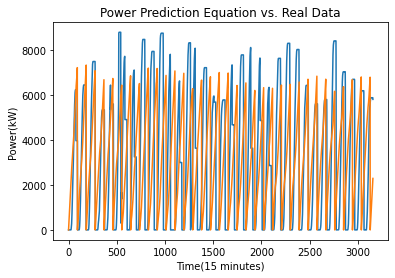

In [143]:
plt.plot(gandikota_avg['Daily_Yield_kW'],label='Real Data')
plt.plot(gandikota_avg['Daily_Yield_pred'],label='Prediction Equation')
plt.title('Power Prediction Equation vs. Real Data')
plt.xlabel('Time(15 minutes)')
plt.ylabel('Power(kW)');

Looks good for the average but lets make sure this works for each indivudal array as well

In it's original format, the gandikota dataset is sorted by date_time first, meaning that for each 15 minute interval there will be 22 entires for each array.

In this case, I'll need to sort it by array so I can iterate through the dataset and get a sum for each individual array. That way I can compare the equation against each array as opposed to the plant's average

In [10]:
gandikota_sorted = gandikota.sort_values(['Array_Source_Key','Date_Time'])
gandikota_sorted = gandikota_sorted.reset_index()

In [11]:
gandikota_sorted.head()

,index,Unnamed: 0,Date_Time,Plant_ID,Array_Source_Key,DC_Power_kW,AC_Power_kW,Daily_Yield_kW,Total_Yield_kW,Date,Sensor_Source_Key,Ambient_Temperature_C,Module_Temperature_C,Irradition
0,0,0,2020-05-15 00:00:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,21,21,2020-05-15 00:15:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,42,42,2020-05-15 00:30:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,63,63,2020-05-15 00:45:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,84,84,2020-05-15 01:00:00,4135001.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


Now that it's sorted I'm going to apply both equations to the data and add them to dictionaries. With the key being the array # and the value being a list of each corresponding variable

In [12]:
g_arrays = gandikota['Array_Source_Key'].unique()
T_pred_dict = {}
Power_pred_dict = {}
Daily_Yield_pred_dict = {}
for codes in g_arrays:
    array = gandikota.loc[gandikota['Array_Source_Key'] == codes]
    array = array.reset_index()
    num_range = []
    Array_T_Cell_pred = []
    for i in range(len(array)):
        T_Air = array['Ambient_Temperature_C'][i]
        NOCT =  noct['gandikota'][0]
        S = array['Irradition'][i]*1000
        T_Cell = T_Air + ((NOCT - 20)/80)*S
        Array_T_Cell_pred.append(T_Cell)
    T_pred_dict[codes] = Array_T_Cell_pred    
    
    Array_Power_pred = []
    for i in range(len(array)):
        T_Cell = T_pred_dict[codes][i]
        a = gand_coefs['a'][0]
        b = gand_coefs['b'][0]
        c = gand_coefs['c'][0]
        Power = T_Cell*a*b*c*0.97 #DELETE THIS LATER AFTER RUNNING
        Array_Power_pred.append(Power)
    Power_pred_dict[codes] = Array_Power_pred
    
    Daily_Yield_pred = []
    for i in range(len(array)):
        f = i-1
        if f < 0:
            pred = 0
        else:
            pred = Power_pred_dict[codes][i]
        Daily_Yield_pred.append(pred)
    Daily_Yield_pred_dict[codes] = Daily_Yield_pred

Now we have a dictionary that contains each array as the keys and a list of each predicted power value as the values

And just like before we're going to simulate daily yield by adding up the first 92 cells and resetting when a new day starts at 00:00:00

In [13]:
full_yield_pred_dict = {}
for arrays in Daily_Yield_pred_dict.keys():
    for i in range(len(Daily_Yield_pred_dict[arrays])):
        f = i-1
        if f < 0:
            pred_sum = 0
        pred_sum = Daily_Yield_pred_dict[arrays][i] + Daily_Yield_pred_dict[arrays][f]
        if i % 92 == 0:
            Daily_Yield_pred_dict[arrays][i] = 0
        else:
            Daily_Yield_pred_dict[arrays][i] = pred_sum
    full_yield_pred_dict[arrays] = Daily_Yield_pred_dict[arrays]

To better visualize this, lets create a dataframe so that we can compare each of the 22 arrays side by side

In [14]:
total_l = []
comp_total_l = []
array_names = []
for i in full_yield_pred_dict.keys():
    values = full_yield_pred_dict[i]
    array_names.append(i)
    
    total = sum(values)
    total_l.append(total)
    
    comp_values = gandikota.loc[gandikota['Array_Source_Key'] == i]
    comp_total = sum(comp_values['Daily_Yield_kW'])
    comp_total_l.append(comp_total)
comparison_df = pd.DataFrame()
comparison_df['array_names'] = array_names
comparison_df['predicted_output'] = total_l
comparison_df['real_output'] = comp_total_l
comparison_df['difference_(real-predicted)'] = comparison_df['real_output'] - comparison_df['predicted_output']
comparison_df['coefficient_(real/predicted)'] = comparison_df['real_output'] / comparison_df['predicted_output']

comparison_df

,array_names,predicted_output,real_output,difference_(real-predicted),coefficient_(real/predicted)
0,1BY6WEcLGh8j5v7,1.010853e+07,1.018950e+07,80969.900458,1.008010
1,1IF53ai7Xc0U56Y,1.050291e+07,1.046451e+07,-38390.930359,0.996345
2,3PZuoBAID5Wc2HD,1.051125e+07,1.046668e+07,-44576.723302,0.995759
3,7JYdWkrLSPkdwr4,1.037650e+07,1.041976e+07,43262.112887,1.004169
4,McdE0feGgRqW7Ca,1.025870e+07,1.037773e+07,119027.651768,1.011603
5,VHMLBKoKgIrUVDU,1.037650e+07,1.067493e+07,298429.752570,1.028760
6,WRmjgnKYAwPKWDb,1.051125e+07,1.026081e+07,-250445.091161,0.976174
7,ZnxXDlPa8U1GXgE,1.042854e+07,1.057318e+07,144638.952736,1.013870
8,ZoEaEvLYb1n2sOq,1.026350e+07,1.015531e+07,-108185.787062,0.989459
9,adLQvlD726eNBSB,1.050291e+07,1.059794e+07,95031.298192,1.009048


It looks like about half of the arrays predictions are slightly above the real output, and the other half are slightly below the real output. This makes sense because the coefficient for the average predictions is right around 1.

In [15]:
comparison_df['coefficient_(real/predicted)'].mean()

0.9978898443856997

It will be tough to find a coefficient better than this, but lets compare to other models to find the closest one

## Model Selection<a id='Model_Selection'></a>

To find a prediction model that is statistically the most similar to the equation, we'll need to test different types of models to ensure we're getting the best model. In this case we'll be testing:

- Linear Regression
- Random Forest
- Gradient Boosting

To determine which one performs the best

### Linear Regression<a id='Linear_Regression'></a>

Let's start with a simple linear regression with four features
- DC Power
- Ambient Temperature
- Module Temperature
- Irradition

These four are the most correlated with power yield in addition to AC Power, but because AC Power is practically the same as DC Power we'll leave it out to avoid bias

For this model to work we'll need a new variable: yield delta. This shows us how much the yield changes per each 15 minute interval as opposed to the cumulative sum that it is now as daily yield

In [16]:
yield_delta = []
for i in range(len(gandikota_avg)):
    f = i+1
    if f >= len(gandikota_avg):
        f = f-1
    delta = gandikota_avg['Daily_Yield_kW'][f] - gandikota_avg['Daily_Yield_kW'][i]
    if delta < 0:
        delta = 0
        yield_delta.append(delta)
    else:
        yield_delta.append(delta)
gandikota_avg['yield_delta'] = yield_delta

In [17]:
gandikota_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3157 non-null   object 
 1   DC_Power_kW            3157 non-null   float64
 2   AC_Power_kW            3157 non-null   float64
 3   Daily_Yield_kW         3157 non-null   float64
 4   Ambient_Temperature_C  3157 non-null   float64
 5   Module_Temperature_C   3157 non-null   float64
 6   Irradition             3157 non-null   float64
 7   T_Cell_pred            3157 non-null   float64
 8   Power_pred             3157 non-null   float64
 9   Daily_Yield_pred       3157 non-null   float64
 10  yield_delta            3157 non-null   float64
dtypes: float64(10), object(1)
memory usage: 271.4+ KB


Looks good, now for the regression!

Score:  0.9761535352041193
Weights:  [ 2.84187274e-02 -4.92393306e-01  1.43100085e-01 -5.02927265e+01]


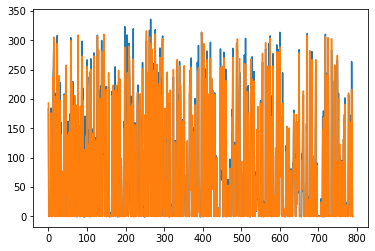

In [18]:
from sklearn import linear_model, preprocessing 
from sklearn.model_selection import train_test_split 

X = np.array(gandikota_avg[['DC_Power_kW','Ambient_Temperature_C','Module_Temperature_C','Irradition']])
y = np.array(gandikota_avg['yield_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 30)
rModel = linear_model.LinearRegression(normalize=True)

rModel.fit(X_train, y_train)

power_pred = rModel.predict(X_test)

print('Score: ', rModel.score(X_test, y_test))
print('Weights: ', rModel.coef_)

plt.plot(rModel.predict(X_test))
plt.plot(y_test)
plt.show();

Looks really good, even though it's a pretty small sample size this fit and score will be hard to top.

### Random Forest<a id='Random_Forest'></a>

In this case we've alread defined the X and y train and test sets so we can go ahead and create a pipeline for this model

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [21]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [22]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.7580264 , 0.40491374, 0.92099012, 0.84161467, 0.96006131])

In [23]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.7771212481848643, 0.198609046848183)

We can definetely do better by tuning some hyperparameters

In [24]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None],
 'simpleimputer__strategy': ['mean', 'median']}

In [25]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [26]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                           

In [27]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 12,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In this case the mean strategy works best and with 12 estimators. Let's apply this best estimator value to our pipeline and get our cross validation scores

In [28]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.7666083 , 0.40348454, 0.96291567, 0.89230308, 0.95397156])

In [29]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.7958566311052968, 0.2083373683458307)

This score is actually really good, lets see how it compares to the next model: gradient boosting

### Gradient Boosting<a id='Gradient_Boosting'></a>

In [30]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbModel = GradientBoostingRegressor()
gbModel.fit(X_train, y_train)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=67)
n_scores = cross_val_score(gbModel, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

MAE: -8.061 (1.738)


The ideal MAE is 0 so let's try to get closer by tuning the hyperparameters. This model just had the default number of trees but lets see if there's a more ideal number

>10 -31.364 (2.891)
>20 -14.195 (1.564)
>30 -9.518 (1.119)
>40 -8.332 (1.092)
>50 -8.009 (1.105)
>60 -7.882 (1.111)
>70 -7.855 (1.168)
>80 -7.870 (1.203)
>90 -7.886 (1.196)
>100 -7.913 (1.214)
>500 -8.464 (1.347)


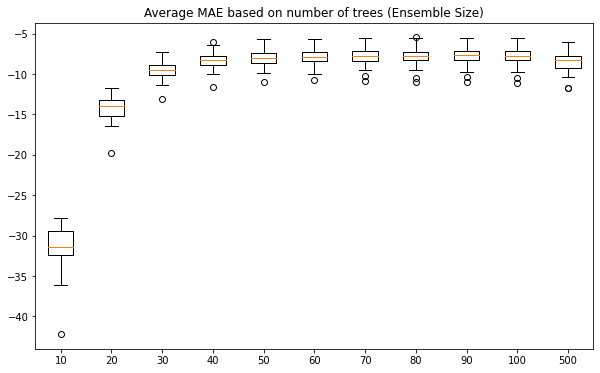

In [31]:
def get_models():
    models = dict()
    n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n)
        models[str(n)].fit(X_train,y_train)
    return models

def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

fig,ax = fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.boxplot(results, labels=names)
plt.title('Average MAE based on number of trees (Ensemble Size)')
plt.show();

Looks like 70 is ideal for the ensemble size in this model

In [32]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbModel_best = GradientBoostingRegressor(n_estimators=67)
gbModel_best.fit(X_train, y_train)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(gbModel_best, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=67,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

MAE: -7.862 (1.159)


This mean absolute error is not bad, when we tested the average predicted equation data against real data we got a MAE of -3 which is really close. Gradient Boosting looks like the best model right now but lets test to make sure this is the case.

## Testing Each Model Against Predicted Data<a id='Testing_Each_Model_Against_Predicted_Data'></a>

Just like with out equation, all our model needs it four features to make a prediction (DC Power, Ambient Temperature, Module Temperature, and Irradition), so if we create sample values for each and compare each model's output to the equation's, we should be able to determine the best model for this scenario.

Lets create a random list of 100 values for each feature, then put each model to the test

In [33]:
gandikota.describe()

,Unnamed: 0,Plant_ID,DC_Power_kW,AC_Power_kW,Daily_Yield_kW,Total_Yield_kW,Ambient_Temperature_C,Module_Temperature_C,Irradition
count,68774.000000,68774.0,68774.000000,68774.000000,68774.000000,6.877400e+04,68774.000000,68774.000000,68774.000000
mean,34388.258223,4135001.0,3147.177450,307.778375,3295.834644,6.978728e+06,25.558521,31.244997,0.232305
std,19855.194820,0.0,4036.441826,394.394865,3145.220597,4.162707e+05,3.361300,12.308283,0.301948
min,0.000000,4135001.0,0.000000,0.000000,0.000000,6.183645e+06,20.398505,18.140415,0.000000
25%,17193.250000,4135001.0,0.000000,0.000000,0.000000,6.512007e+06,22.724491,21.123944,0.000000
50%,34386.500000,4135001.0,428.571429,41.450000,2658.473214,7.146685e+06,24.670178,24.818984,0.031620
75%,51583.750000,4135001.0,6365.468750,623.561161,6274.000000,7.268751e+06,27.960429,41.693659,0.454880
max,68777.000000,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06,35.252486,65.545714,1.221652


To make 100 random values for each variable I'm going to use their min and max values as the high and low for the random range. For example the high for DC_power is 14471 and the low is 0 so the code would look like:
- random_dc = random.randint(0,14471)   

and vice versa for each variable

In [34]:
import random
DC_dummies = []
Amb_dummies = []
Mod_dummies = []
Irr_dummies = []

for i in range(100):
    # DC Power random values - range (0,14470) in dataset
    dc = random.randint(0,14471)
    DC_dummies.append(dc)
    
    # Ambient Temp random values - range (20,35) in dataset
    at = random.randint(20,35)
    Amb_dummies.append(at)
    
    # Module Temp random values - range(18,65) in dataset
    mt = random.randint(18,65)
    Mod_dummies.append(mt)
    
    # Irradition random values - range(0,1.2) in dataset
    ir = random.randint(0,120)
    Irr_dummies.append(ir/100)
    
random_test_df = pd.DataFrame()
random_test_df['DC_dummies'] = DC_dummies
random_test_df['Amb_dummies'] = Amb_dummies
random_test_df['Mod_dummies'] = Mod_dummies
random_test_df['Irr_dummies'] = Irr_dummies

Now we can plug in our random variables to the second equation to see what the power output values should look like

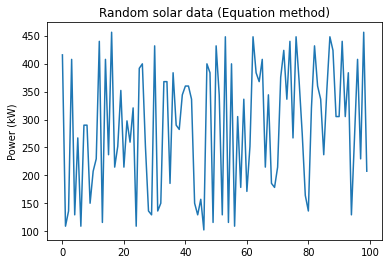

In [35]:
equation_sample = []
for x in Mod_dummies:
    x = (x*gand_coefs['a'][0]*gand_coefs['b'][0]*gand_coefs['c'][0])
    equation_sample.append(x)
plt.plot(equation_sample)
plt.title('Random solar data (Equation method)')
plt.ylabel('Power (kW)');

So with this random data the values should look just like the equation says, let's compute the same thing with out models

Equation Prediction Sum: 28708.405690112537
Linear Regression Sum: 16600.770324897316 Coefficient: 0.5782546932104553
Random Forest Sum: 21178.96391195064 Coefficient: 0.737726927108491
Gradient Boosting Sum: 28094.81700826494 Coefficient: 0.9786268632096514


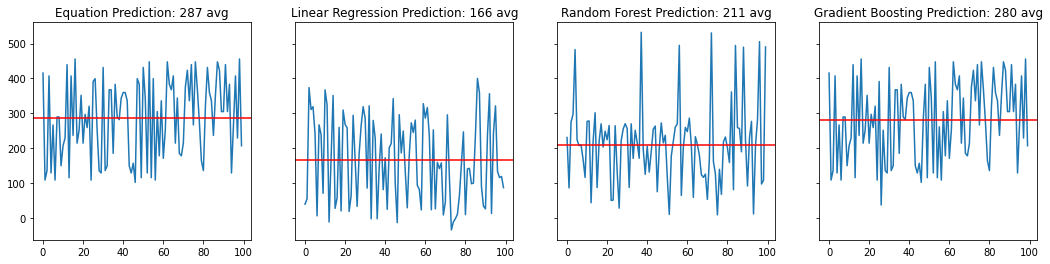

In [36]:
random_x_test = np.array(random_test_df[['DC_dummies','Amb_dummies','Mod_dummies','Irr_dummies']])
lr_random_predict = rModel.predict(random_x_test)
rf_random_predict = rf_grid_cv.predict(random_x_test)
gb_random_predict = gbModel_best.predict(random_x_test)

random_x_mean = int(np.mean(equation_sample))
lr_mean = int(np.mean(lr_random_predict))
rf_mean = int(np.mean(rf_random_predict))
gb_mean = int(np.mean(gb_random_predict))

fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(18,4))
ax[0].plot(equation_sample)
ax[0].axhline(y=random_x_mean, color='r', linestyle='-')
ax[0].set_title('Equation Prediction: ' + str(random_x_mean) + ' avg')
ax[1].plot(lr_random_predict)
ax[1].axhline(y=lr_mean, color='r', linestyle='-')
ax[1].set_title('Linear Regression Prediction: ' + str(lr_mean) + ' avg')
ax[2].plot(rf_random_predict)
ax[2].axhline(y=rf_mean, color='r', linestyle='-')
ax[2].set_title('Random Forest Prediction: ' + str(rf_mean) + ' avg')
ax[3].plot(gb_random_predict)
ax[3].axhline(y=gb_mean, color='r', linestyle='-')
ax[3].set_title('Gradient Boosting Prediction: ' + str(gb_mean) + ' avg')

print('Equation Prediction Sum:', sum(equation_sample))
print('Linear Regression Sum:',sum(lr_random_predict),'Coefficient:' ,sum(lr_random_predict)/sum(equation_sample))
print('Random Forest Sum:',sum(rf_random_predict),'Coefficient:' ,sum(rf_random_predict)/sum(equation_sample))
print('Gradient Boosting Sum:',sum(gb_random_predict),'Coefficient:' ,sum(gb_random_predict)/sum(equation_sample))
fig.show;

Looks like the average for the equation is most similar to gradient, the real dataset has many more than 100 entries though. Let's try a larger sample size

Here we'll do the same thing but with 10000 random values

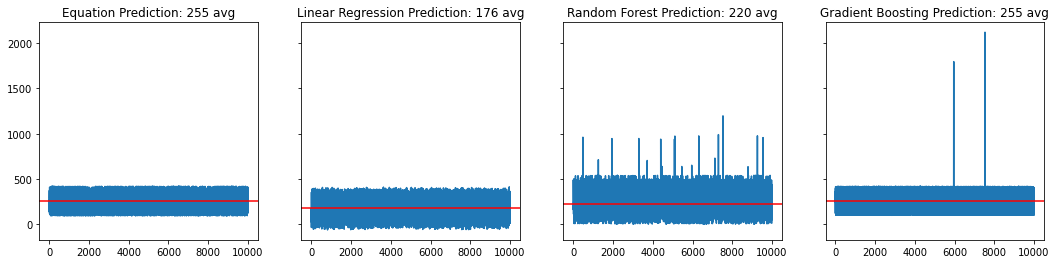

In [162]:
DC_dummies = []
Amb_dummies = []
Mod_dummies = []
Irr_dummies = []

for i in range(10000):
    # DC Power random values - range (0,14470) in dataset
    dc = random.randint(0,14470)
    DC_dummies.append(dc)
    
    # Ambient Temp random values - range (20,35) in dataset
    at = random.randint(20,35)
    Amb_dummies.append(at)
    
    # Module Temp random values - range(18,65) in dataset
    mt = random.randint(18,65)
    Mod_dummies.append(mt)
    
    # Irradition random values - range(0,1.2) in dataset
    ir = random.randint(0,120)
    Irr_dummies.append(ir/100)
    
random_test_df = pd.DataFrame()
random_test_df['DC_dummies'] = DC_dummies
random_test_df['Amb_dummies'] = Amb_dummies
random_test_df['Mod_dummies'] = Mod_dummies
random_test_df['Irr_dummies'] = Irr_dummies

equation_sample = []
for x in Mod_dummies:
    x = ((x**1.14)*gand_coefs['a'][0]*gand_coefs['b'][0]*gand_coefs['c'][0])
    equation_sample.append(x)
    
random_x_test = np.array(random_test_df[['DC_dummies','Amb_dummies','Mod_dummies','Irr_dummies']])
lr_random_predict = rModel.predict(random_x_test)
rf_random_predict = rf_grid_cv.predict(random_x_test)
gb_random_predict = gbModel_best.predict(random_x_test)

random_x_mean = int(np.mean(equation_sample))
lr_mean = int(np.mean(lr_random_predict))
rf_mean = int(np.mean(rf_random_predict))
gb_mean = int(np.mean(gb_random_predict))


fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(18,4))
ax[0].plot(equation_sample)
ax[0].axhline(y=random_x_mean, color='r', linestyle='-')
ax[0].set_title('Equation Prediction: ' + str(random_x_mean) + ' avg')
ax[1].plot(lr_random_predict)
ax[1].axhline(y=lr_mean, color='r', linestyle='-')
ax[1].set_title('Linear Regression Prediction: ' + str(lr_mean) + ' avg')
ax[2].plot(rf_random_predict)
ax[2].axhline(y=rf_mean, color='r', linestyle='-')
ax[2].set_title('Random Forest Prediction: ' + str(rf_mean) + ' avg')
ax[3].plot(gb_random_predict)
ax[3].axhline(y=gb_mean, color='r', linestyle='-')
ax[3].set_title('Gradient Boosting Prediction: ' + str(gb_mean) + ' avg')
fig.show;

What happens if we remove those outliers?

Equation Prediction Sum: 2553139.8252355265
Gradient Boosting Sum: 2553961.3922476377 Coefficient: 1.0003217869244727


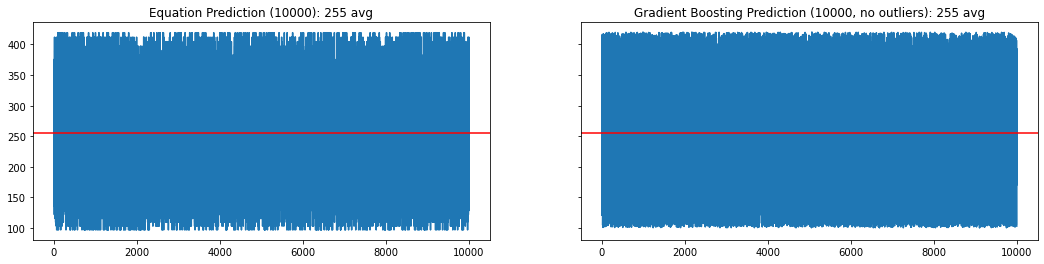

In [163]:
gb_random_predict_no_outlier = [x for x in gb_random_predict if x < 550]
gb_mean_no_outlier = int(np.mean(gb_random_predict_no_outlier))
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(18,4))
ax[0].plot(equation_sample)
ax[0].axhline(y=random_x_mean, color='r', linestyle='-')
ax[0].set_title('Equation Prediction (10000): ' + str(random_x_mean) + ' avg')
ax[1].plot(gb_random_predict_no_outlier)
ax[1].axhline(y=gb_mean_no_outlier, color='r', linestyle='-')
ax[1].set_title('Gradient Boosting Prediction (10000, no outliers): ' + str(gb_mean) + ' avg')

print('Equation Prediction Sum:', sum(equation_sample))
print('Gradient Boosting Sum:',sum(gb_random_predict),'Coefficient:' ,sum(gb_random_predict)/sum(equation_sample))

fig.show;

Looks like the gradient boosting model is the best for accurately predicted the average power output, even over a random set of 10,000

## Gandikota Historical Data and Model Performance<a id='Gandikota_Historical_Data_and_Model_Performance'></a>

Now that we have a working model, we can use it predict what the power output of the plant will be. First we'll need to find good weather data we can use to make this prediction.

Fortunately, OpenWeatherMap is a great source for historical meteorological data! For just $10 I found a dataset that contains and hour by hour breakdown of all weather data in Gandikota since 2000

In [39]:
gandikota_historical = pd.read_csv('Data/gandikota_historical.csv')
gandikota_historical.describe()

,dt,timezone,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,irradiation,weather_id
count,1.841270e+05,184127.0,1.841270e+05,1.841270e+05,184127.000000,184127.000000,184127.000000,184127.000000,184127.000000,0.0,0.0,184127.000000,184127.00000,184127.000000,16676.000000,0.0,0.0,0.0,184127.000000,184127.000000
mean,1.278111e+09,19800.0,1.481493e+01,7.828629e+01,29.105231,30.566635,28.589420,29.638933,1008.905712,NaN,NaN,61.751476,3.43673,182.060947,0.831290,NaN,NaN,NaN,55.437741,772.924291
std,1.913504e+08,0.0,5.039716e-11,2.736876e-10,4.815830,4.830310,4.766527,4.884937,4.046854,NaN,NaN,19.034305,1.78776,90.518429,1.097166,NaN,NaN,NaN,39.954383,88.081670
min,9.466848e+08,19800.0,1.481493e+01,7.828629e+01,14.320000,-0.390000,14.070000,14.410000,992.000000,NaN,NaN,7.000000,0.01000,0.000000,0.040000,NaN,NaN,NaN,0.000000,200.000000
25%,1.112398e+09,19800.0,1.481493e+01,7.828629e+01,25.870000,27.540000,25.450000,26.310000,1006.000000,NaN,NaN,47.000000,2.10000,101.000000,0.210000,NaN,NaN,NaN,14.000000,800.000000
50%,1.278112e+09,19800.0,1.481493e+01,7.828629e+01,28.730000,30.400000,28.210000,29.270000,1009.000000,NaN,NaN,64.000000,3.22000,153.000000,0.440000,NaN,NaN,NaN,60.000000,802.000000
75%,1.443825e+09,19800.0,1.481493e+01,7.828629e+01,32.210000,33.630000,31.630000,32.850000,1012.000000,NaN,NaN,78.000000,4.54000,268.000000,1.000000,NaN,NaN,NaN,98.000000,804.000000
max,1.609456e+09,19800.0,1.481493e+01,7.828629e+01,45.040000,48.730000,43.980000,45.750000,1022.000000,NaN,NaN,100.000000,57.62000,360.000000,16.060000,NaN,NaN,NaN,100.000000,804.000000


In [40]:
gandikota_historical.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,irradiation,weather_id,weather_main,weather_description,weather_icon
0,946684800,2000-01-01 00:00:00 +0000 UTC,19800,Gandikota,14.814927,78.286287,18.58,19.59,17.90,19.08,...,89,NaN,NaN,NaN,NaN,8,800,Clear,sky is clear,01n
1,946688400,2000-01-01 01:00:00 +0000 UTC,19800,Gandikota,14.814927,78.286287,18.31,19.44,17.63,18.92,...,95,NaN,NaN,NaN,NaN,29,802,Clouds,scattered clouds,03n
2,946692000,2000-01-01 02:00:00 +0000 UTC,19800,Gandikota,14.814927,78.286287,20.64,22.47,20.08,21.17,...,92,NaN,NaN,NaN,NaN,74,803,Clouds,broken clouds,04d
3,946695600,2000-01-01 03:00:00 +0000 UTC,19800,Gandikota,14.814927,78.286287,20.84,21.82,20.42,21.30,...,95,NaN,NaN,NaN,NaN,48,802,Clouds,scattered clouds,03d
4,946699200,2000-01-01 04:00:00 +0000 UTC,19800,Gandikota,14.814927,78.286287,21.04,20.76,20.83,21.23,...,98,NaN,NaN,NaN,NaN,78,803,Clouds,broken clouds,04d


We'll be using this data to see how much power was generated each year and then predict the generation for 2021, for now though let's verify that this data works with out model

To do this, let's find the exact dates in the original dataset, make a slice of the new dataset based on those dates, apply the model to make a power generation prediction, then compare it to the real generation data. I know we're doing a lot of validation but that's the most important step when creating a model!

In [41]:
# Generation dates: 2020-05-16 to 2020-06-17

datetimefix = [x[:-10] for x in gandikota_historical['dt_iso']]
gandikota_historical['dt_iso'] = datetimefix

In [42]:
gandikota_historical['dt_iso'] = pd.to_datetime(gandikota_historical['dt_iso'])

test_dates = gandikota_historical[(gandikota_historical.dt_iso >= '2020-05-16 00:00:00') & (gandikota_historical.dt_iso <= '2020-06-17 23:00:00')]
test_dates = test_dates.reset_index()
test_dates.describe()

,index,dt,timezone,lat,lon,temp,feels_like,temp_min,temp_max,pressure,...,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,irradiation,weather_id
count,792.000000,7.920000e+02,792.0,7.920000e+02,7.920000e+02,792.000000,792.000000,792.000000,792.000000,792.000000,...,0.0,792.000000,792.000000,792.000000,40.000000,0.0,0.0,0.0,792.000000,792.000000
mean,178979.500000,1.591011e+09,19800.0,1.481493e+01,7.828629e+01,33.556806,35.531490,32.784293,34.318081,1004.781566,...,NaN,54.752525,4.294369,241.372475,1.650000,NaN,NaN,NaN,65.753788,787.460859
std,228.774999,8.235900e+05,0.0,7.287665e-14,1.066488e-12,4.060411,4.152591,4.016625,4.138387,2.425427,...,NaN,15.541938,2.170734,76.775002,1.014005,NaN,NaN,NaN,34.656249,66.237293
min,178584.000000,1.589587e+09,19800.0,1.481493e+01,7.828629e+01,25.720000,27.320000,25.420000,25.920000,998.000000,...,NaN,21.000000,0.220000,0.000000,0.500000,NaN,NaN,NaN,0.000000,500.000000
25%,178781.750000,1.590299e+09,19800.0,1.481493e+01,7.828629e+01,30.330000,32.260000,29.630000,31.000000,1003.000000,...,NaN,42.000000,2.635000,248.000000,1.000000,NaN,NaN,NaN,33.000000,801.000000
50%,178979.500000,1.591011e+09,19800.0,1.481493e+01,7.828629e+01,32.930000,34.845000,32.135000,33.790000,1005.000000,...,NaN,55.000000,4.180000,261.000000,1.000000,NaN,NaN,NaN,76.000000,803.000000
75%,179177.250000,1.591723e+09,19800.0,1.481493e+01,7.828629e+01,36.562500,38.235000,35.815000,37.442500,1007.000000,...,NaN,67.000000,5.442500,278.000000,2.000000,NaN,NaN,NaN,100.000000,804.000000
max,179375.000000,1.592435e+09,19800.0,1.481493e+01,7.828629e+01,42.730000,47.240000,42.180000,43.390000,1011.000000,...,NaN,89.000000,11.800000,360.000000,5.000000,NaN,NaN,NaN,100.000000,804.000000


Now let's apply the model

The main difference here is that this model has Irradiation in cm^2 which means we have to multiply by 100 to match the values in the original dataset

In [180]:
irr_prediction = test_dates['irradiation']*10000
AmbT_prediction = test_dates['temp']

CellT_prediction = []
for i in range(len(test_dates)):
    T_Air = AmbT_prediction[i]
    NOCT =  noct['gandikota'][0]
    S = irr_prediction[i]
    T_Cell = T_Air + ((NOCT - 20)/80)*S
    CellT_prediction.append(T_Cell)

DC_prediction = []
for i in range(len(CellT_prediction)):
    DC = CellT_prediction[i]*gand_coefs['a'][0]
    DC_prediction.append(DC)

prediction_df = pd.DataFrame()
prediction_df['DC'] = DC_prediction
prediction_df['AmbT'] = AmbT_prediction
prediction_df['CellT'] = CellT_prediction
prediction_df['Irr'] = irr_prediction

model_prediction = gbModel_best.predict(prediction_df)

total_yield_prediction = sum(model_prediction)

Because the data is taken hourly instead of every 15 minutes, we'll have to multiply each instance by 4. In addition to this we'll have to multiply the total power by 22 to get the cumulative sum for the entire power plant. This is because the model was designed to predict just one array

In [181]:
model_prediction_total_output = total_yield_prediction*4*22
actual_output = sum(gandikota['Total_Yield_kW'][68751:68773])
coef = model_prediction_total_output/actual_output

print('Total output based on original dataset (kW): ', actual_output)
print('Total output based on model and historical dataset (kW): ',model_prediction_total_output)
print('Coefficient: ',coef)

Total output based on original dataset (kW):  156142755.0
Total output based on model and historical dataset (kW):  155893881.92858523
Coefficient:  0.9984061183535876


Wow, this confirms that:

- The model works, very well! 
- Both datasets match up in the temperature and irradiation fields
- We can confidently use the model AND this new data to make accurate predictions

## Predicting Power Output for 2021<a id='Predicting_Power_Output_for_2021'></a>

There's a few ways we can do this, here's how I'll be doing it:

- Divide the historical data into a dictionary, with the keys being each year and the values being every datetime instance with that year
- Find the corresponding temperature values for each datetime isntance
- Apply the equation to find Module Temperature and DC Power
- Create new dataframes for each year, apply the model
- Sum the model, multiply by 4 and 22 to determine a yearly sum of generated power

First let's create a dictionary with the year as it's keys and each date of that year as it's values

You might notice that 2020 is missing, I'll explain why later on

In [45]:
import datetime

years = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
years_dt = []
for i in years:
    d = datetime.datetime(i,1,1)
    years_dt.append(d)

years_dict = {}
for year in range(len(years)):
    current_year = years[year]
    date_list = []
    for i in range(len(gandikota_historical)):
        date = gandikota_historical['dt_iso'][i]
        if date.year == current_year:
            date_list.append(date)
    years_dict[current_year] = date_list

Now that we have our years dictionary we can apply the equation to calculate our variables for the model, Each day has an ambient temperature and irradiation value which we can convert to cell temperature using the NOCT equation and DC Power using the second equation. We won't be using the full second equation to predict power because our model will be doing that part for us

In [46]:
years_power_dict = {}
for y in years_dict.keys():
    power_list = []
    mod_temp_list = []
    amb_temp_list = []
    DC_list = []
    irr_list =[]
    mod_df = pd.DataFrame()
    for index,date in enumerate(years_dict[y]):
        temp = gandikota_historical[gandikota_historical['dt_iso'] == date]['temp']
        amb_temp_list.append(temp)
        irr = (gandikota_historical[gandikota_historical['dt_iso'] == date]['irradiation'])*100
        irr_list.append(irr)
        NOCT =  noct['gandikota'][0]
        T_Cell = amb_temp_list[index] + ((NOCT - 20)/80)*irr
        mod_temp_list.append(T_Cell)
    for x in range(len(years_dict[y])):
        DC = mod_temp_list[x]*gand_coefs['a'][0]
        DC_list.append(DC)
                                   
    mod_df['DC'] = DC_list
    mod_df['Amb_temp'] = amb_temp_list
    mod_df['mod_temp'] = mod_temp_list
    mod_df['irr'] = irr_list

    model_year_prediction = gbModel_best.predict(mod_df)
                                   
    years_power_dict[y] = model_year_prediction

For some reason, the data from 2020 was causing an error because it was nested in a numpy array. Because of this I decided to calculate the years 2000-2019 with this function and calculate 2020 seperately below

In [47]:
date_2020_list = []
current_2020 = 2020
for i in range(len(gandikota_historical)):
    date = gandikota_historical['dt_iso'][i]
    if date.year == current_2020:
        date_2020_list.append(date)

In [48]:
power_2020 = []
mod_2020 = []
amb_2020 = []
DC_2020 = []
irr_2020 = []
mod_2020_df = pd.DataFrame()

for index,date in enumerate(date_2020_list):
    temp = gandikota_historical[gandikota_historical['dt_iso'] == date]['temp']
    temp = temp.values
    amb_2020.append(temp[0])
    irr = (gandikota_historical[gandikota_historical['dt_iso']==date]['irradiation']*100)
    irr = irr.values
    irr_2020.append(irr[0])
    NOCT = noct['gandikota'][0]
    mod = amb_2020[index] + ((NOCT - 20)/80)*irr
    mod_2020.append(mod[0])
for x in range(len(date_2020_list)):
    DC = mod_2020[x]*gand_coefs['a'][0]
    DC_2020.append(DC)

mod_2020_df['DC'] = DC_2020
mod_2020_df['amb'] = amb_2020
mod_2020_df['mod'] = mod_2020
mod_2020_df['irr'] = irr_2020

year_2020_pred = gbModel_best.predict(mod_2020_df)

I solved the numpy problem by using .values and then the first [0]  slice to only add values to the dataframe

Now we can create a full list of the total power generated each year

In [50]:
yearly_total_list = []
for i in years_power_dict.keys():
    x = np.sum(years_power_dict[i])
    yearly_total_list.append(x)
yearly_total_list.append(np.sum(year_2020_pred))
yearly_total_list

[1549688690.4973161,
 1530785553.8666124,
 1523079923.7099967,
 1580863741.5015938,
 1466728993.3135679,
 1561220225.8262584,
 1487097367.285005,
 1515842247.161306,
 1490382381.7371492,
 1490116548.0480719,
 1606799614.3887362,
 1479962510.112446,
 1532494860.235383,
 1519426099.6152723,
 1590448572.6929166,
 1560137652.5775135,
 1547824427.7218306,
 1475551012.3710551,
 1576794402.1360893,
 1544959562.96228,
 1546807222.2733169]

Lets see what this looks like on a graph

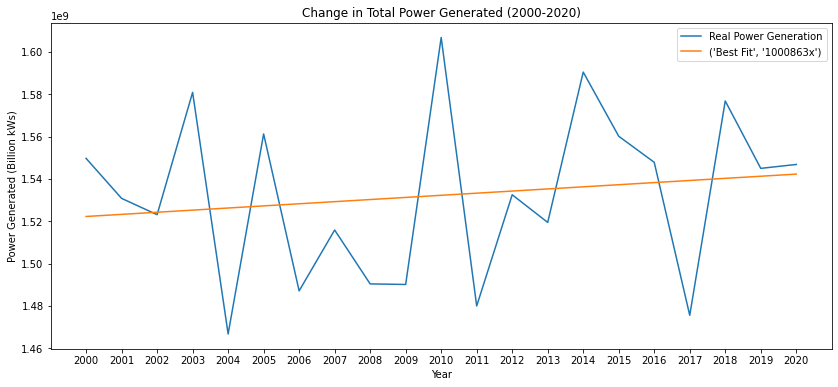

In [53]:
fig,ax=plt.subplots(figsize=(14,6))

years_full = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
X = years_full
Y = yearly_total_list

def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X)
    
    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return a, b
a, b = best_fit(X, Y)


plt.plot(years_full,yearly_total_list,label='Real Power Generation')
yfit = [a + b * xi for xi in X]
slope = str(int(b))+'x'
lab_bf = ("Best Fit",slope)
plt.plot(X, yfit,label=lab_bf)
plt.title('Change in Total Power Generated (2000-2020)')
plt.xticks(years_full)
plt.xlabel('Year')
plt.legend()
plt.ylabel('Power Generated (Billion kWs)');

Looks like the generated power has a positive trend over the past 20 years. This could be for many reasons, maybe even global warming, but we can use it to predict the power generation for 2021 and beyond

We'll start by making a copy of the power dictionary so that we can edit it and add the 2021 prediction when we're done

In [54]:
years_power_dict_full = years_power_dict.copy()
years_power_dict_full[2020] = year_2020_pred

I'll make a list the same size as the 2020 list (because it's the largest list) and make each value 0 so that we can iterate

In [134]:
total = len(years_power_dict_full[2020])

year_2021_pred = [0] * total

And finally, to make a prediction we're going to sum the power generation from each day in each year (as in sum of all power generated on January 1st 20XX) divide it by the length of the years_full list and then add the slope from the best fit line above divided by the len of the full list

There's no way we can accurately predict the generation without knowing the weather but if we follow the trends of the past 20 years we can get a good idea!

In [135]:
for year in years_full:
    for i in range(len(years_power_dict_full[year])):
        year_2021_pred[i] += years_power_dict_full[year][i]
for i in range(len(year_2021_pred)):
    year_2021_pred[i] = year_2021_pred[i]/len(years_full)
    year_2021_pred[i] += b/len(year_2021_pred)
    
    year_2021_pred[i] = year_2021_pred[i]

In [137]:
year_2021_pred[0:5]

[164190.62293356634,
 184869.9766604456,
 184299.3768467019,
 173851.77421605823,
 163606.88699014933]

Using the results from our model plus the historical coefficient, we can finally make a solid prediction for how much power the solar array will generate in 2021!

Let's visualize this

2000 1549688690.4972775
2001 1530785553.866617
2002 1523079923.7099702
2003 1580863741.5015433
2004 1466728993.3135533
2005 1561220225.8262403
2006 1487097367.2849991
2007 1515842247.1612837
2008 1490382381.737122
2009 1490116548.048052
2010 1606799614.388671
2011 1479962510.1124182
2012 1532494860.2353518
2013 1519426099.6152222
2014 1590448572.692865
2015 1560137652.5774624
2016 1547824427.7217512
2017 1475551012.3710005
2018 1576794402.13602
2019 1544959562.9622276
2020 1546807222.2732768


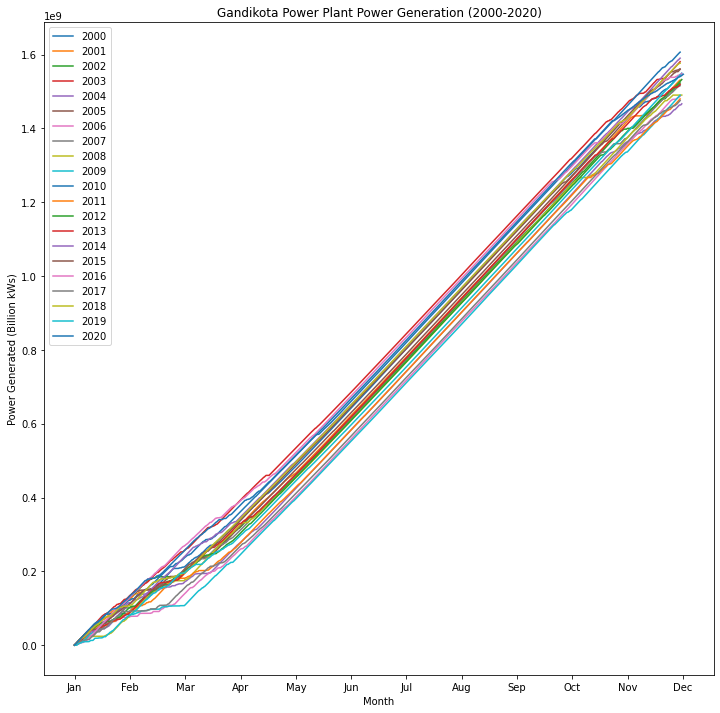

In [187]:
fig,ax=plt.subplots(figsize=(12,12))
for i in years_power_dict.keys():
    print(i, sum(years_power_dict[i]))
    if i == 2019:
        print(2020, sum(year_2020_pred))
    plt.plot(np.cumsum(years_power_dict[i]),label=i)
plt.plot(np.cumsum(year_2020_pred),label=2020)

plt.title("Gandikota Power Plant Power Generation (2000-2020)")

x_ticks = np.arange(0, 8807, 800)
xtick_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(x_ticks)
ax.set_xticklabels(xtick_labels)
plt.xlabel("Month")
plt.ylabel("Power Generated (Billion kWs)")
plt.legend();

Lets see what the 2021 prediction looks like next to the other years

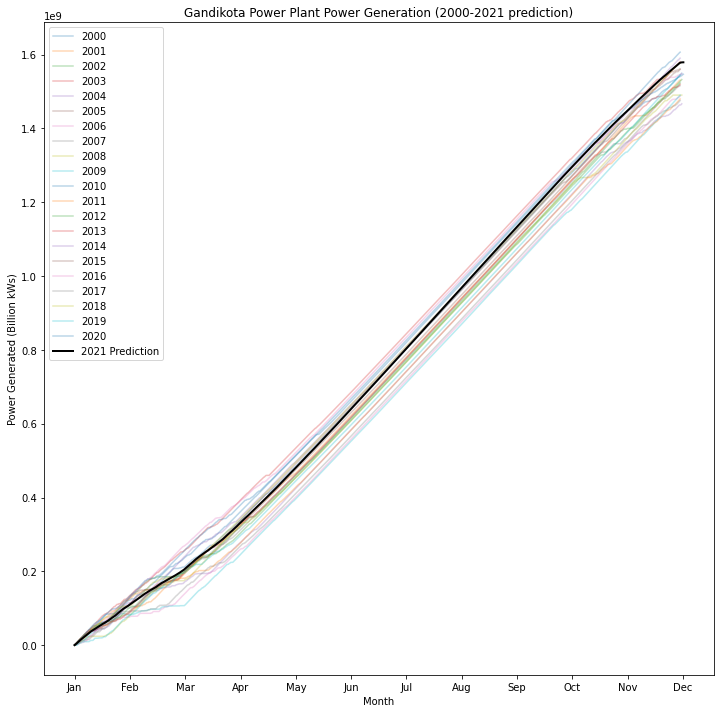

In [139]:
fig,ax=plt.subplots(figsize=(12,12))
for i in years_power_dict.keys():
    plt.plot(np.cumsum(years_power_dict[i]),label=i,alpha=0.3)
plt.plot(np.cumsum(year_2020_pred),label=2020,alpha=0.3)

plt.plot(np.cumsum(year_2021_pred),label='2021 Prediction',linewidth=2,color='black')
plt.title("Gandikota Power Plant Power Generation (2000-2021 prediction)")

x_ticks = np.arange(0, 8807, 800)
xtick_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(x_ticks)
ax.set_xticklabels(xtick_labels)
plt.xlabel("Month")
plt.ylabel("Power Generated (Billion kWs)")
plt.legend();

It's not very exciting but it fits right in with the rest of the data! The model looks good compared to the real data and it seems like each year is adding up to a very similar level of generation.

So we have our answer, according to our equation, machine learning mode, and coefficient based on 20 years of historical data, the solar power plant in Gandikota, India will generate:

In [185]:
print(sum(year_2021_pred),'kWs')

1579236697.30106 kWs


## Conclusion and Next Steps<a id='Conclusion_and_Next_Steps'></a>

Now we finally have our answer, we can make a solid prediction for how much power the plant will generate for 2021 and beyond. What can we actually do with this? What questions can we answer or solutions can we provide?

In the next notebook I'll be adding a business element to this by seeing 

- How much money does the solar power plant make each year?
- How much more could they be making by upgrading their solar arrays to ones with an average or above average NOCT? (reminder: average NOCT is around 25 and these arrays are around 18)


For now though, let me demonstrate the effectiveness of machine learning and why we need statistics and models to answer questions like this

For example, lets say instead of going through all this trouble I just decided to take the 32 days of data I had and just multiply the totals by 365/32 to see an estimate, what would that look like?

In [91]:
#5-16, 6-17 = 32 days
simple_sum = sum(gandikota['Total_Yield_kW'][68751:68773])

simple_sum_2020 = simple_sum*(365/32)
print('simple sum:',simple_sum_2020)

x = sum(year_2020_pred)
print('ML model prediction:',x)

simple sum: 1781003299.21875
ML model prediction: 1546807222.2732768


As you can see the simple sum if off by over 200,000,000 kW, which makes sense given that this data was taken during a relatively warm time of the year

To better visualize how far off this 'simple sum' prediction would be here's a bar chart that shows the predicted power output vs what the output would be if we just multiplied our data.

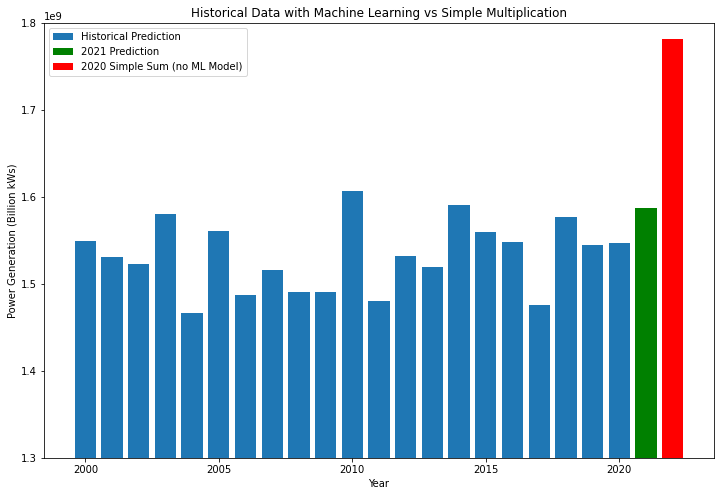

In [140]:
year_2021_sum = sum(year_2021_pred)
year_2021_sum = year_2021_sum*1.005

fig,ax=plt.subplots(figsize=(12,8))
ax.set(ylim=[1300000000, 1800000000])
plt.bar(years_full,yearly_total_list,label = 'Historical Prediction')
plt.bar(2021,year_2021_sum, label='2021 Prediction',color='green')
plt.bar(2022,simple_sum_2020, label='2020 Simple Sum (no ML Model)',color='red')
plt.title('Historical Data with Machine Learning vs Simple Multiplication')
plt.xlabel('Year')
plt.ylabel('Power Generation (Billion kWs)')
plt.legend();

As you can see, the simple sum method is a huge outlier. This shows the importance of using machine learning when making complex predictions like this!

We'll answer some more questions in the next notebook but for now thank you for going through everything!

In [200]:
import pickle

filename = 'solar_power_prediction_model.sav'
pickle.dump(model, open(filename, 'wb'))